# Explicabilidade

Os gráficos SHAP (SHapley Additive exPlanations) são uma boa forma de visualizar a importancia das features utilizadas e tirar insights de como as features estão ajudando o modelo a prever o target.

Plota-se abaixo alguns gráficos SHAP para se obter mais insights sobre as features e seu impacto na predição do target.

Para plotar os gráficos abaixo, precisa-se dos seguintes artefatos gerados nos notebooks anteriores:

- shap_values
    - caminho: '../data/08_reporting/<nome_do_arquivo>.npy'

- X_test_scaled
    - caminho: '../data/03_primary/<nome_do_arquivo>.npy'

- selected_features
    - caminho: '../data/08_reporting/<nome_do_arquivo>.npy'

- modelo
    -  caminho: '../data/06_models/<nome_do_arquivo>.joblib'

- explainer
    - caminho: '../data/08_reporting/<nome_do_arquivo>.pkl'
    


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib #Para salvar o modelo
import pickle
import os
import utils


2025-10-22 09:06:39.503220: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 09:06:39.531954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 09:06:40.557326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Features selecionadas

caminho_features_selecionadas_all_features = '../data/08_reporting/selected_features_all_features.npy'

caminho_features_selecionadas_non_linear_features = '../data/08_reporting/selected_non_linear_features.npy'

caminho_features_selecionadas_linear_features = '../data/08_reporting/selected_linear_features_features.npy'

# Caso os dvalores shapa já estejam calculados

caminho_shap_all_features = '../data/08_reporting/shap_values_calculados_all_features.npy'

caminho_shap_non_linear_features = '../data/08_reporting/shap_values_calculados.npy'

caminho_shap_linear_features = '../data/08_reporting/shap_values_calculados_linear_features.npy'

# Conjunto de treino normalizado para plotar o gráfico

caminho_X_train_all_features = '../data/03_primary/X_train_all_features.npy'

caminho_X_train_non_linear_features = '../data/03_primary/X_train_non_linear_features.npy'

caminho_X_train_linear_features = '../data/03_primary/X_train_linear_features.npy'

# Target de treino normalizado

caminho_y_train_all_features = '../data/03_primary/y_train_all_features.npy'

caminho_y_train_non_linear_features = '../data/03_primary/y_train_non_linear_features.npy'

caminho_y_train_linear_features = '../data/03_primary/y_train_linear_features.npy'

# Conjunto de teste normalizado para plotar o gráfico

caminho_X_test_shap_all_features = '../data/03_primary/X_test_final_para_shap_all_features.npy'

caminho_X_test_shap_non_linear_features = '../data/03_primary/X_test_final_para_shap.npy'

caminho_X_test_shap_linear_features = '../data/03_primary/X_test_final_para_shap_linear_features.npy'

# Target de teste normalizado

caminho_y_teste_shap_all_features = '../data/03_primary/y_test_final_para_shap_all_features.npy'

caminho_y_teste_shap_non_linear_features = '../data/03_primary/y_test_final_para_shap_non_linear_features.npy'

caminho_y_teste_shap_linear_features = '../data/03_primary/y_test_final_para_shap_linear_features.npy'

# shap explainers

caminho_explainer_all_features = '../data/08_reporting/explainer_expected_value_all_features.pkl'

caminho_explainer_non_linear_features = '../data/08_reporting/explainer_expected_value.pkl'

caminho_explainer_linear_features = '../data/08_reporting/explainer_expected_value_linear_features.pkl'

# modelos

caminho_modelo_all_features = '../data/06_models/modelo_notebook_2_all_data.joblib'

caminho_modelo_non_linear_features = '../data/06_models/modelo_notebook_3.joblib'

caminho_modelo_linear_features = '../data/06_models/modelo_notebook_4.joblib'

# 1 - Modelo com todas as features

Carregando ou calculando artefatos:

In [3]:
if not os.path.exists(caminho_modelo_all_features):
    # Lança um erro se o arquivo não for encontrado
    raise FileNotFoundError(
        f"ERRO: O modelo '{caminho_modelo_all_features}' não foi encontrado. "
        "Execute o notebook/script de treinamento do modelo primeiro."
    )

else:
    # Carregamento dos dados necessários
    X_test_scaled = np.load(caminho_X_test_shap_all_features, allow_pickle=True)
    y_test_scaled = np.load(caminho_y_teste_shap_all_features, allow_pickle=True)

    # Carregamento dos nomes das features
    with open(caminho_features_selecionadas_all_features, 'rb') as f:
        loaded_data = pickle.load(f)
    selected_feature_names = loaded_data['list']

    # Carregamento do modelo (usando o caminho verificado)
    best_nn_model = joblib.load(caminho_modelo_all_features)



    # Verificação da existência dos SHAP Values e Expected Value (para evitar recálculo)
    if os.path.exists(caminho_shap_all_features) and os.path.exists(caminho_explainer_all_features):
        print("Valores SHAP e Expected Value já existem. Carregando...")
        
        # Carregar os valores salvos
        shap_values = np.load(caminho_shap_all_features, allow_pickle=True)
        
        # Carregar o Expected Value (que você salvou)
        with open(caminho_explainer_all_features, 'rb') as f:
            expected_value = pickle.load(f)
            
    else:
        print("Valores SHAP e Expected Value não encontrados. Iniciando o cálculo demorado...")
        
        X_train_scaled = np.load(caminho_X_train_all_features, allow_pickle=True)

        # O KernelExplainer usa um "background dataset"
        X_background = shap.sample(X_train_scaled, 100) 

        # --- Definir o Explainer ---
        # Crie o Explainer para calcular os valores
        explainer = shap.KernelExplainer(
            best_nn_model.predict, 
            X_background
        )

        # --- Calcular os Valores SHAP ---
        shap_values = explainer.shap_values(X_test_scaled)
        expected_value = explainer.expected_value # Obtenha o valor base aqui

        # --- SALVAR OS VALORES (PARA EVITAR FUTUROS RECÁLCULOS) ---
        np.save(caminho_shap_all_features, shap_values)

        # Salvar o Expected Value (resolvendo o problema de pickle.dump anterior)
        with open(caminho_explainer_all_features, 'wb') as f:
            pickle.dump(expected_value, f)

        print("Cálculo concluído. Valores SHAP e Expected Value salvos.")

Valores SHAP e Expected Value já existem. Carregando...


In [4]:
if not os.path.exists(caminho_shap_all_features):
    # Lança um erro se o arquivo não for encontrado
    raise FileNotFoundError(
        f"ERRO: Os valores shap contidos em '{caminho_shap_all_features}' não foi encontrado. "
        "Execute o notebook/script de treinamento do modelo primeiro."
    )

else:
    
    if isinstance(shap_values, list):
        # Pega o primeiro elemento da lista 
        shap_values_array = shap_values[0]

    else:
        shap_values_array = shap_values

    # ACHATA o array de (2000, 510, 1) para (2000, 510)
    shap_values_plot = np.squeeze(shap_values_array)

    # Verificação após o squeeze 
    print(f"Novo Shape de shap_values_plot: {shap_values_plot.shape}") 

Novo Shape de shap_values_plot: (2000, 510)


## 1.1 - Gráfico de Resumo Global (Summary Plot - Importância das Features)

Este é o gráfico mais importante e mostra a importância global das features.

    - Eixo Y: Features ordenadas por importância.

    - Eixo X: Valor SHAP.

    - Cor: Valor da feature (azul = baixo valor da feature, vermelho = alto valor da feature).

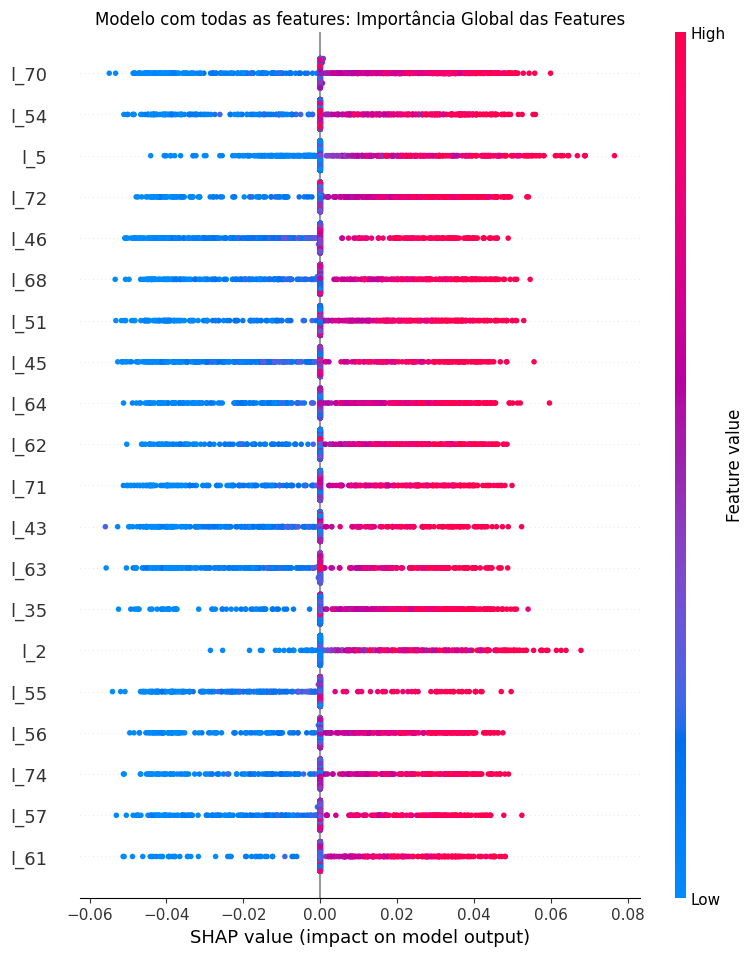

In [5]:
utils.plot_shap_summary(
    shap_values=shap_values,
    shap_values_plot=shap_values_plot,
    X_test_scaled=X_test_scaled,
    selected_feature_names=selected_feature_names,
    title="Modelo com todas as features: Importância Global das Features",
    save_filename='../data/08_reporting/shap_summary_plot_all_features.png'
)

### Explicação do gráfico acima

O Gráfico de Resumo SHAP é a maneira mais concisa de entender a importância e a direção do impacto de cada feature nas previsões.


- Eixo Y: Lista as features (variáveis de entrada), ordenadas da mais importante (topo) para a menos importante (base), com base na magnitude média dos seus valores SHAP.

- Eixo X: Representa o Valor SHAP. Este valor indica a contribuição (positiva ou negativa) de uma feature para a previsão do modelo em relação ao valor de previsão base (média).

- Cor do Ponto: Representa o valor real da feature para aquela observação. Geralmente, Vermelho = Alto Valor da Feature (Alto na escala escalada) e Azul = Baixo Valor da Feature (Baixo na escala escalada).

- Dispersão dos Pontos,Cada ponto é uma observação individual do conjunto de teste. A dispersão horizontal mostra o quão variável é o impacto dessa feature entre as observações. Quanto maior a dispersão de uma feature que já foi avaliada como importante, maior é a interação entre as features do modelo.




### Significado Visual do Gráfico

- Linha de Base: O ponto central, geralmente rotulado como E[f(x)] (o Valor Base/Média, 0.5108), é o ponto de partida da previsão.

- Setas Vermelhas (Forças Positivas): Representam as features que estão aumentando o valor da previsão, empurrando-a para a direita em direção ao valor mais alto.

- Setas Azuis (Forças Negativas): Representam as features que estão diminuindo o valor da previsão, empurrando-a para a esquerda em direção ao valor mais baixo.

- Comprimento da Seta: Indica a magnitude do impacto daquela feature. Setas mais longas significam uma contribuição mais forte.

### Interpretação dos Resultados da Observação 0

A previsão de r (0.2748) é significativamente inferior ao valor médio (0.5108).

Isto implica que, para esta observação específica, o modelo identificou que as características predominantes (setas azuis) puxaram a previsão para baixo, resultando em uma estimativa de r bem abaixo da média.

## 1.2 - Gráfico de Força (Force Plot - Explicação Local)

O gráfico abaixo explica uma única previsão. Ele mostra como cada feature empurra a previsão da linha de base (valor médio) para o valor final previsto.


--- Explicação SHAP Force Plot para a Observação 0 ---
Valor Base (Média): 0.4533
Valor Previsto: 0.2599
--------------------------------------------------
Force Plot salvo em: ../data/08_reporting/shap_force_plot_all_features_obs_0.png


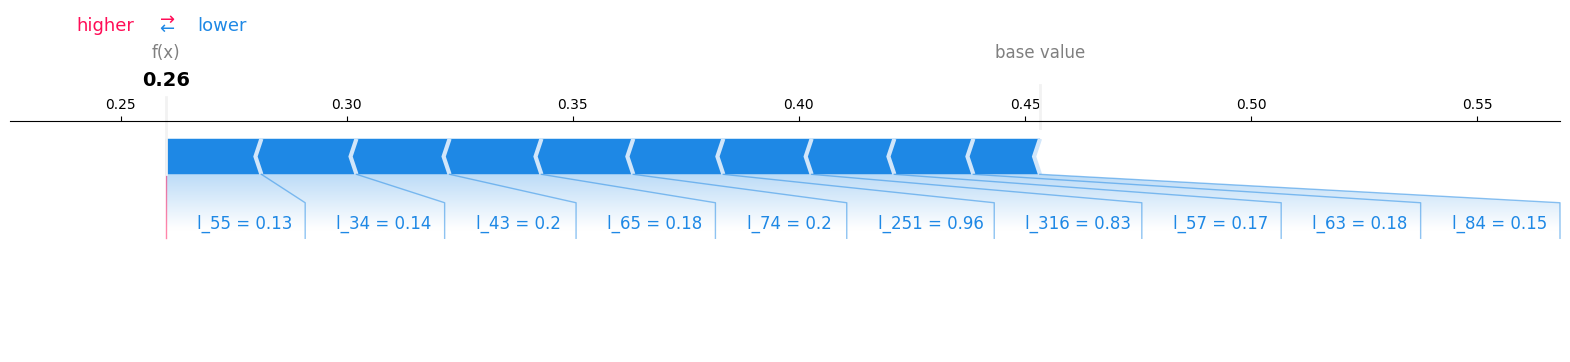

In [6]:
if not os.path.exists(caminho_shap_all_features):
    # Lança um erro se o arquivo não for encontrado
    raise FileNotFoundError(
        f"ERRO: Os valores shap contidos em '{caminho_shap_all_features}' não foi encontrado. "
        "Execute o notebook/script de treinamento do modelo primeiro."
    )

else:
    observation_index = 0

    utils.generate_shap_force_plot(
        model = best_nn_model,
        explainer_expected_value = expected_value,
        shap_values_plot = shap_values_plot,
        X_test_scaled = X_test_scaled,
        selected_feature_names= selected_feature_names,
        observation_index = observation_index,
        save_filename_prefix = '../data/08_reporting/shap_force_plot_all_features',
        dpi = 300
    )

## Explicação do gráfico acima

O Force Plot (Gráfico de Força) fornece uma explicação local, detalhando exatamente como cada feature da Observação 0 contribuiu para a previsão final do modelo.

A observação 0 é a primeira linha do dataset.

- Valor Base (Média): 0.4533,
    - Significado: É a previsão média de r (ou a média dos targets escalados) para todo o conjunto de dados. Representa o ponto de partida do modelo antes de considerar as features específicas da observação.
- Valor Previsto: 0.2599
    - Significado: É o valor final previsto para r pelo modelo, após considerar todas as features específicas da Observação 0."

## Significado Visual do Gráfico

- Linha de Base: O ponto central, geralmente rotulado como E[f(x)] (o Valor Base/Média, 0.5108), é o ponto de partida da previsão.

- Setas Vermelhas (Forças Positivas): Representam as features que estão aumentando o valor da previsão, empurrando-a para a direita em direção ao valor mais alto.

- Setas Azuis (Forças Negativas): Representam as features que estão diminuindo o valor da previsão, empurrando-a para a esquerda em direção ao valor mais baixo.

- Comprimento da Seta: Indica a magnitude do impacto daquela feature. Setas mais longas significam uma contribuição mais forte.

## Interpretação dos Resultados da Observação 0

A previsão de r (0.2599) é significativamente inferior ao valor médio (0.4533).

Isto implica que, para esta observação específica, o modelo identificou que as características predominantes (setas azuis) puxaram a previsão para baixo, resultando em uma estimativa de r bem abaixo da média.

## Observação

- Um valor longe do valor médio, como mostrado no gráfico acima, não indica que o resultado foi ruim.

- Podemos ver nas linhas de código abaixo que o valor `y_test_scaled`, que é o valor real normalizado, ficou próximo do valor normalizado previsto pelo modelo.

In [ ]:
if not os.path.exists(caminho_y_teste_shap_all_features):
    # Lança um erro se o arquivo não for encontrado
    raise FileNotFoundError(
        f"ERRO: Os valores normalizados de y contidos no caminho '{caminho_y_teste_shap_all_features}' não foram encontrados. "
        "Execute o notebook/script de treinamento do modelo primeiro."
    )

else:
    print(y_test_scaled[0])

## 1.3 - Gráfico de Dependência (Dependence Plot - Relação Feature-Target)

O gráfico abaixo ajuda a entender a forma (linear ou não linear) da relação entre uma feature e o target.

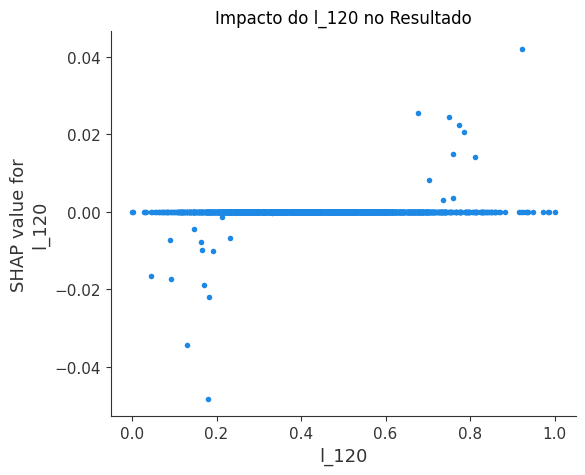

In [18]:
if not os.path.exists(caminho_shap_all_features):
    # Lança um erro se o arquivo não for encontrado
    raise FileNotFoundError(
        f"ERRO: Os valores shap contidos em '{caminho_shap_all_features}' não foi encontrado. "
        "Execute o notebook/script de treinamento do modelo primeiro."
    )

else:
    
    # Explicando a relação da feature mais importante 
    most_important_feature = 'l_120' # Substitua pelo nome da sua feature principal

    shap.dependence_plot(
        most_important_feature, 
        shap_values_plot, 
        X_test_scaled, 
        interaction_index=None, # Não mostra interação com outra feature
        show=False,
        feature_names=selected_feature_names
    )
    plt.title(f"Impacto do {most_important_feature} no Resultado")
    plt.show()


    plt.savefig(
        f'../data/08_reporting/shap_dependence_plot_{most_important_feature}_all_features.png', 
        dpi=300, 
        bbox_inches='tight'
    )
    plt.clf()
    plt.close()